In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the Numenta Anomaly Benchmark(NAB) dataset. It provides artificial timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
df_train = pd.read_csv('Stocks\GOOG.csv')
df_test = pd.read_csv('Stocks\TestAnomaly.csv')

In [3]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [4]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2024,139.600006,140.615005,137.740005,139.559998,139.559998,20071900.0
1,1/3/2024,138.600006,141.089996,138.429993,140.360001,140.360001,18974300.0
2,1/4/2024,139.850006,140.634995,138.009995,138.039993,138.039993,18253300.0
3,1/5/2024,138.352005,138.809998,136.850006,137.389999,137.389999,15433200.0
4,1/8/2024,138.000000,140.639999,137.880005,140.529999,140.529999,17645300.0


### Quick look at train data

In [5]:
df_train = df_train[['Date', 'Close']]
df_train['Date'] = pd.to_datetime(df_train['Date'], format="%Y-%m-%d")
df_train.set_index('Date', inplace=True)


In [6]:
df_test = df_test[['Date', 'Close']]
df_test['Date'] = pd.to_datetime(df_test['Date'], format="%m/%d/%Y")
df_test.set_index('Date', inplace=True)

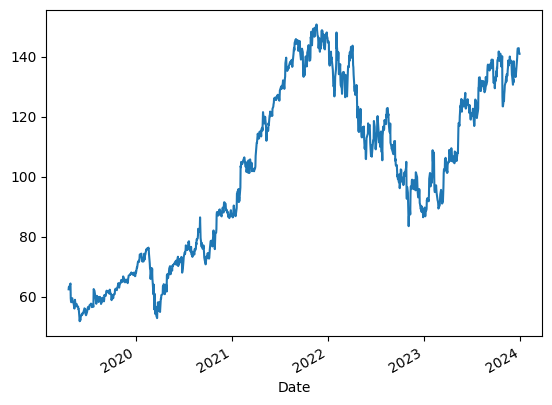

In [7]:
fig, ax = plt.subplots()
df_train.plot(legend=False, ax=ax)
plt.show()

### Quick look at test data

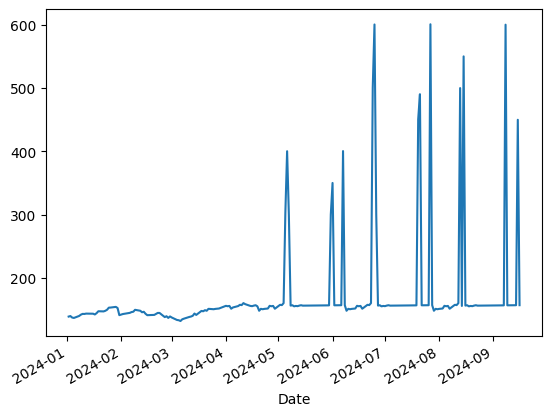

In [8]:
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
plt.show()

In [9]:
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
df_test_value = (df_test - training_mean) / training_std

print(df_training_value)

               Close
Date                
2019-04-22 -1.336916
2019-04-23 -1.309923
2019-04-24 -1.324614
2019-04-25 -1.311813
2019-04-26 -1.296813
...              ...
2023-12-22  1.421768
2023-12-26  1.425205
2023-12-27  1.377782
2023-12-28  1.372284
2023-12-29  1.360256

[1183 rows x 1 columns]


**Data Time Period**

## Data Preprocessing

#### 2. Data Scaling

In [10]:
# scaler = StandardScaler()
# scaler = scaler.fit(np.array(df_train['value']).reshape(-1,1))

# df_train['scaled_value'] = scaler.transform(np.array(df_train['value']).reshape(-1,1))
# df_test['scaled_value'] = scaler.transform(np.array(df_test['value']).reshape(-1,1))

In [11]:
df_train.head()

,Close
Date,
2019-04-22,62.442001
2019-04-23,63.227501
2019-04-24,62.799999
2019-04-25,63.172501
2019-04-26,63.609001


#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 2 as we want our network to have memory of last 2 days.

In [12]:
TIME_STEPS=32

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


X_train = create_sequences(df_training_value.values)
print("Training input shape: ", X_train.shape)

X_test = create_sequences(df_test_value.values)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1152, 32, 1)
Testing input shape:  (195, 32, 1)


In [13]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [14]:
from keras import layers
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(filters=32,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Conv1DTranspose(filters=16,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            256       
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 16)             3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 16, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 32)           3616      
 ranspose)                                              

In [15]:
# Encoder 
encoder = Sequential()
encoder.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
encoder.add(LSTM(64, activation='tanh'))
encoder.add(Dropout(rate=0.1))
encoder.add(RepeatVector(X_train.shape[1]))
# Decoder 
decoder = Sequential()
decoder.add(LSTM(64, activation='tanh', return_sequences=True))
decoder.add(LSTM(256, activation='tanh', return_sequences=True))
decoder.add(Dropout(rate=0.1))
decoder.add(TimeDistributed(Dense(X_train.shape[2])))

# Autoencoder
model = Sequential([encoder, decoder])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

## Train Model

In [16]:
history = model.fit(X_train,
                    X_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')])

Epoch 1/50
9/9 [==============================] - 2s 47ms/step - loss: 0.8702 - val_loss: 1.1175
Epoch 2/50
9/9 [==============================] - 0s 13ms/step - loss: 0.4942 - val_loss: 0.6501
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 0.2134 - val_loss: 0.1945
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1460 - val_loss: 0.1075
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1150 - val_loss: 0.1124
Epoch 6/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0967 - val_loss: 0.0905
Epoch 7/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0881 - val_loss: 0.0838
Epoch 8/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0817 - val_loss: 0.0714
Epoch 9/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0733 - val_loss: 0.0631
Epoch 10/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0661 - val_loss: 0.0579
Epoch 11/50
9/9 [============

#### Plot Training - Validation loss

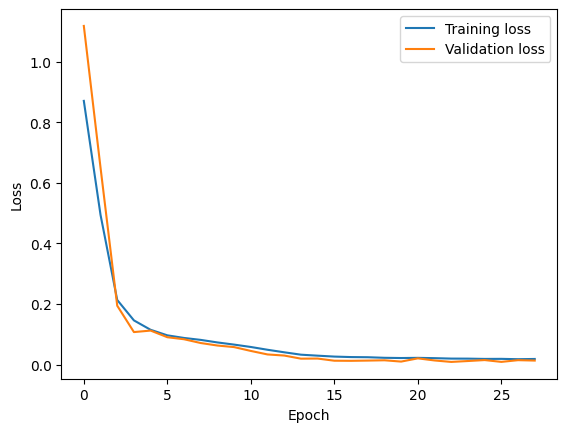

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [18]:
X_train_pred = model.predict(X_train)

36/36 [==============================] - 0s 2ms/step


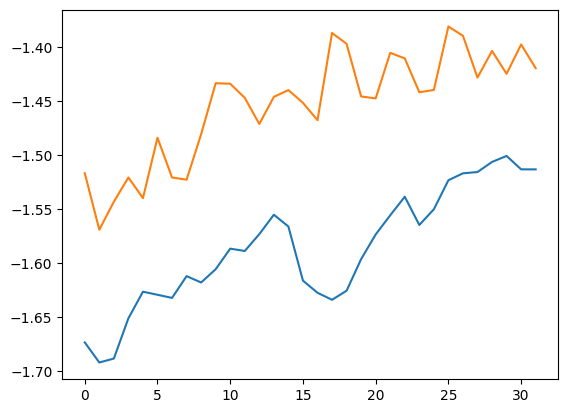

In [19]:
plt.plot(X_train[30])
plt.plot(X_train_pred[30])
plt.show()

Reconstruction error threshold: 0.140382456698154


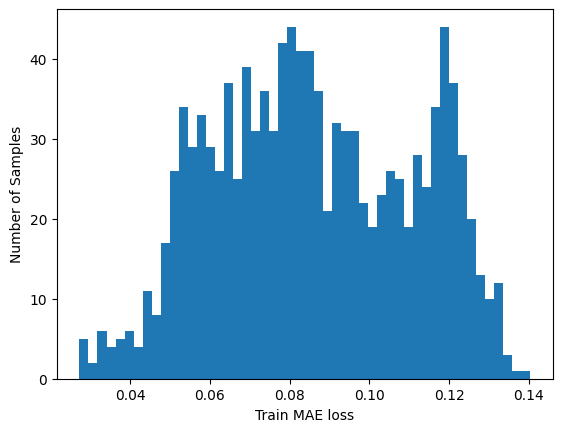

In [20]:
# Mean Absolute Error loss
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)
#threshold = threshold + 0.10*threshold

print('Reconstruction error threshold:',threshold)

## Predict Anomalies on test data using threshold

7/7 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Number of samples')

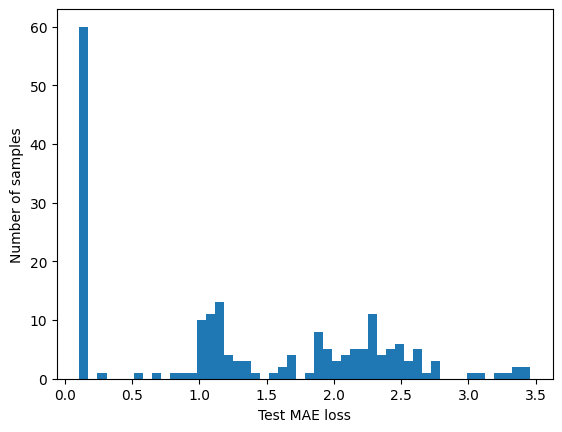

In [21]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

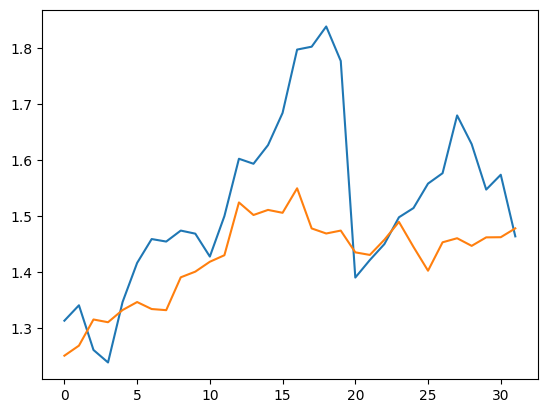

In [22]:
plt.plot(X_test[0])
plt.plot(X_test_pred[0])
plt.show()

In [23]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  138
Indices of anomaly samples:  (array([ 16,  17,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 

In [24]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

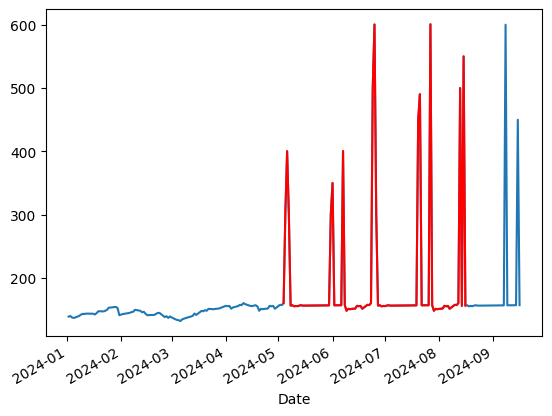

In [25]:
df_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()